In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline



Using TensorFlow backend.


In [3]:
data = pd.read_csv('BitcoinData1.csv', index_col='time')
data.head()

,XEM,IOT,amd,nvda,mc_iota,mc_nem,gg_crypto,gg_nem_p,gg_iota_p,gg_bitcoin_p,gg_nem_w,gg_iota_w,gg_gpu,rd_CrypCurr_g,rd_nem_g,rd_Iota_g
time,,,,,,,,,,,,,,,,
8/28/2017 11:00,0.286,0.8620,12.55,165.100006,2.564020e+09,2.472360e+09,42,73,50,28,45,34,64,1221,57,352
8/28/2017 12:00,0.286,0.8700,12.55,165.100006,2.564020e+09,2.472360e+09,42,73,50,28,45,34,64,1221,57,352
8/28/2017 13:00,0.286,0.8699,12.55,165.100006,2.564020e+09,2.472360e+09,42,73,50,28,45,34,64,1221,57,352
8/28/2017 14:00,0.286,0.8800,12.55,165.100006,2.564020e+09,2.472360e+09,42,73,50,28,45,34,64,1221,57,352
8/28/2017 15:00,0.287,0.8739,12.55,165.100006,2.564020e+09,2.472360e+09,42,73,50,28,45,34,64,1221,57,352


In [4]:
data.drop(data.columns[[0,2,3,4,5,7,8,9,11,12,13,14,15]], axis=1, inplace=True)
print(data.head())


                    IOT  gg_crypto  gg_nem_w
time                                        
8/28/2017 11:00  0.8620         42        45
8/28/2017 12:00  0.8700         42        45
8/28/2017 13:00  0.8699         42        45
8/28/2017 14:00  0.8800         42        45
8/28/2017 15:00  0.8739         42        45


In [5]:
btc_trace = go.Scatter(x=data.index, y=data['IOT'], name= 'IOT')
py.iplot([btc_trace])

In [6]:
# Fill value 0 data points on Weighted Price with NAN and then use ffill method to fill values
data['IOT'].replace(0, np.nan, inplace=True)
data['IOT'].fillna(method='ffill', inplace=True)

In [7]:
btc_trace = go.Scatter(x=data.index, y=data['IOT'], name= 'IOT')
py.iplot([btc_trace])

In [8]:
# Using Weighted Price as a feature to train the LSTM model
# Use MinMaxScaler to normalize Weighted Price to range from 0 to 1

from sklearn.preprocessing import MinMaxScaler
values = data['IOT'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [9]:
#Split 70% of data for training and 30% for testing
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1353 581


In [10]:
# Function to create lookback

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [11]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1352
580


In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)


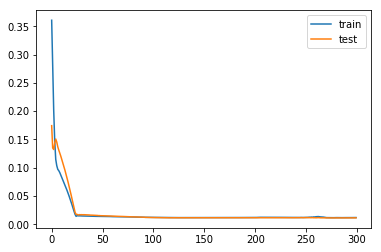

In [14]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

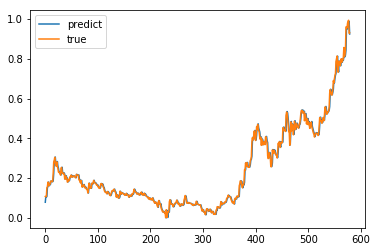

In [15]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [16]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [17]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.010


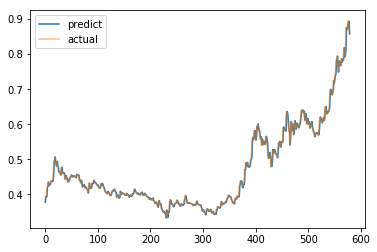

In [18]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [19]:
predictDates = data.tail(len(testX)).index

In [20]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [21]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

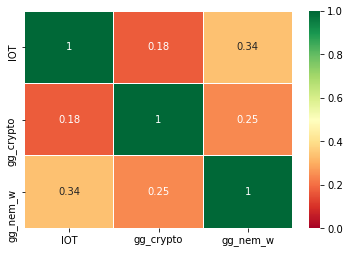

In [22]:
# Using additional features for model training
# Find corrleration in features to Weighted Price
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [23]:
#Observation: Volume is corrlerated to Weighted Price. Open, High, Low, Close are directly related to Weighted Price
#Function to convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [24]:
# Get all other data
values = data[['IOT'] + ['gg_crypto'] + ['gg_nem_w']].values
values = values.astype('float32')

In [25]:
# Normalize features to range from 0 to 1

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [26]:
# Frame as supervised learning

reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.932898,0.194444,0.345238,0.947025,0.194444,0.345238
2,0.947025,0.194444,0.345238,0.946848,0.194444,0.345238
3,0.946848,0.194444,0.345238,0.964683,0.194444,0.345238
4,0.964683,0.194444,0.345238,0.953911,0.194444,0.345238
5,0.953911,0.194444,0.345238,0.938195,0.194444,0.345238


In [27]:
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head()) 

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.932898   0.194444   0.345238  0.947025
2   0.947025   0.194444   0.345238  0.946848
3   0.946848   0.194444   0.345238  0.964683
4   0.964683   0.194444   0.345238  0.953911
5   0.953911   0.194444   0.345238  0.938195


In [28]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1353, 1, 3) (1353,) (580, 1, 3) (580,)


In [29]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

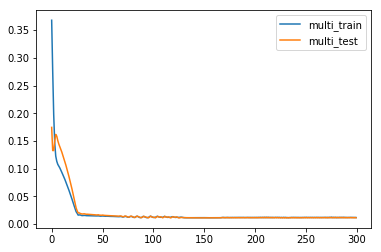

In [30]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

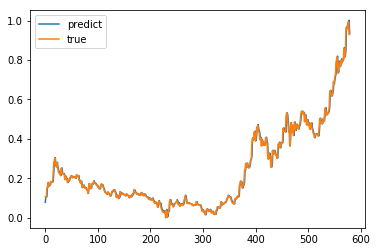

In [31]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [32]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [33]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.010


In [38]:
# Plot line graph with actual price, predicted price with feature Weighted Price,
# predicted price with features Volume and Weighted Price

fig=(24,10)
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])

LSTM with single feature of 'IOT' have RMSE of 0.010
LSTM with features of 'gg_crypto', 'gg_new_w' and 'IOT' also have RMSE of 0.010
LSTM with multi features and single features remain the same